In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **P1**

In [2]:
def newton(MJ, fun, Ti, tol, maxtol, sigma1, sigma2, T0, Tl, Ts, h):
    cumple = False
    i = 0

    while (not cumple) and (i < maxtol):
        jacobiano = MJ(Ti, sigma1, sigma2, h)
        f = fun(Ti, sigma1, sigma2, T0, Tl, Ts, h)
        delta_U = np.linalg.solve(jacobiano,-f)
        Ti = delta_U + Ti

        # Actualizo las condiciones del while
        cumple = np.linalg.norm(delta_U)<= tol
        i = i + 1

    return Ti

In [3]:
def funcion_f(x, sigma1, sigma2, T0, Tl, Ts, h):
    m = len(x)
    F_vector = np.zeros(m)

    F_vector[0] = (1/(h**2)) * (T0 - 2 * x[1] + x[2]) - sigma1 * (x[1] - Ts) - sigma2 * (x[1]**4 - Ts**4)

    for i in range(1, m-1):
        F_vector[i] = (1/(h**2)) * (x[i-1] - 2 * x[i] + x[i+1]) - sigma1 * (x[i] - Ts) - sigma2 * (x[i]**4 - Ts**4)

    F_vector[-1] = (1/(h**2)) * (x[-2] - 2 * x[-1] + Tl) - sigma1 * (x[-1] - Ts) - sigma2 * (x[-1]**4 - Ts**4)

    return F_vector

In [4]:
def jacobian_matrix(x,sigma1, sigma2, h): # len --> n-1
    m = len(x)
    MJ = np.zeros((m,m))

    for i in range(m-1):
        MJ[i,i] = -2 - (sigma1 * h**2) - (4 * sigma2 * x[i]**3)
        MJ[i, i+1] = 1
        MJ[i+1, i] = 1

    MJ[m-1,m-1] = -2 - (sigma1 * h**2) - (4 * sigma2 * x[-1]**3)
    MJ = MJ / (h**2)

    return MJ

In [5]:
hc = 40
P = 0.015
e = 0.4
k = 240
Ac = 1.5 * 10**(-5)
sigma_sb = 5.67 * 10 **(-8)
sigma1 = hc * P / (k * Ac)
sigma2 = e * sigma_sb * P / (k * Ac)
T0 = 475
Tl = 290
Ts = 290
n = 100
h = 0.2/n

x_grilla = [i * h for i in range(0,n+1)]

Tia = [290 for xi in x_grilla]
Tib = [350 for xi in x_grilla]
Tic = [10*xi for xi in x_grilla]

sol_a = newton(jacobian_matrix, funcion_f, Tia[1:-1], 1e-5, 20, sigma1, sigma2, T0, Tl, Ts, h)
sol_a = np.append(np.append(T0,sol_a),Tl)

sol_b = newton(jacobian_matrix, funcion_f, Tib[1:-1], 1e-5, 20, sigma1, sigma2, T0, Tl, Ts, h)
sol_b = np.append(np.append(T0,sol_b),Tl)

sol_c = newton(jacobian_matrix, funcion_f, Tic[1:-1], 1e-5, 20, sigma1, sigma2, T0, Tl, Ts, h)
sol_c = np.append(np.append(T0,sol_c),Tl)

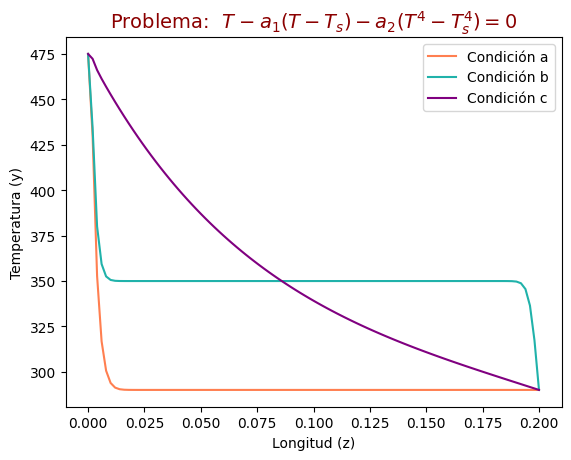

In [6]:
plt.plot(x_grilla, sol_a,label='Condición a', color = 'coral')
plt.plot(x_grilla, sol_b,label='Condición b', color = 'lightseagreen')
plt.plot(x_grilla, sol_c,label='Condición c', color = 'purple')
plt.title(r'Problema:  $T^{''} - a _{1}(T - T_{s}) - a _{2}(T^{4} - T_{s}^{4}) = 0$', color = 'darkred', fontsize = 14)
plt.xlabel("Longitud (z)")
plt.ylabel("Temperatura (y)")
plt.legend()
plt.show()

# **P2**

In [7]:
def RungeKutta_sist(ti, h, f, x):
    F1 = h * f(ti, x)
    F2 = h * f(ti + 0.5 * h, x + 0.5 * F1)
    F3 = h * f(ti + 0.5 * h, x + 0.5 * F2)
    F4 = h * f(ti + h, x + F3)

    return x + 1/6 * (F1 + 2*F2 + 2*F3 +F4)



def estimar_sist(f, u0, hx, ht, a, b):
    n = int((b-a)/abs(hx))
    estimaciones = np.array([[u0(a+i*hx) for i in range(1,n)]])
    ti = [0]
    for i in range(int((b-a)/abs(ht))):
        ti.append(ti[i] + ht)
        est = RungeKutta_sist(ti[i], ht, f, estimaciones[i])
        estimaciones = np.vstack([estimaciones, est])

    return estimaciones, ti

In [8]:
n = 20
b = 1
a = 0
hx = 0.05
ht = 0.01*hx
beta = 1

def g1(t):
    return 0

def u0(x):
    return (x - x**2) * np.exp(x)

def g2(t):
    return 0

def f(t,x):
    return 0


def met_lines(t,u):
    A = beta*(-2* np.eye(n-1) + np.diag(np.ones(n-2), -1) + np.diag(np.ones(n-2), 1))/(hx**2)
    F = [f(t, a + i*hx) for i in range(1,n)]
    F[0] = F[0] + beta*g1(t)/hx**2
    F[-1] = F[-1] + beta*g2(t)/hx**2

    return np.dot(A,u) + F

In [9]:
est_u, ti = estimar_sist(met_lines, u0, hx, ht, a, b)

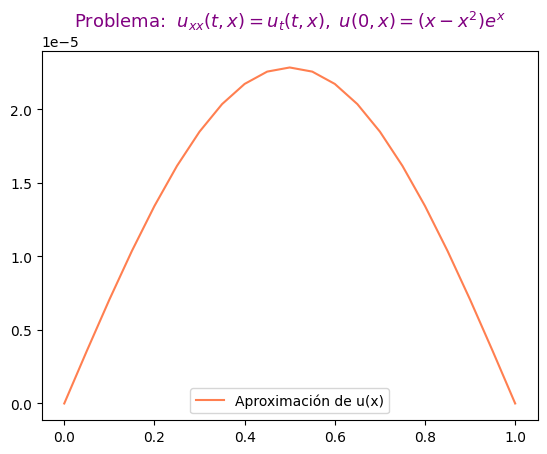

In [10]:
# Agregamos las condiciones de borde
u = [0]*(n+1)
u[0] = 0
u[1:-1] = est_u[-1]
u[-1] = 0

xi = [a+i*hx for i in range(n+1)]

plt.plot(xi, u, label="Aproximación de u(x)", color = 'coral')
plt.title(r'Problema:  $ u_{xx}(t,x) = u_{t}(t,x), \;u(0,x) = (x - x^{2})e^{x}$', color = 'purple', fontsize = 13)
plt.legend()
plt.show()